# Bivariate linear regression

In this tutorial, we introduce the bivariate linear regression based PSM in `cfr`.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

In [2]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)

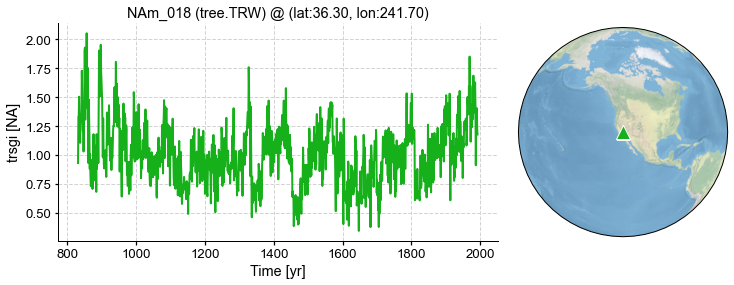

In [3]:
pobj = pdb.records['NAm_018']
fig, ax = pobj.plot()

### Model

In [15]:
dirpath = './data/icesm_last_millennium_historical'

model_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

### Instrumental observations

In [4]:
dirpath = './data/CRUTS'

obs_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [5]:
obs_pr = obs_pr.rename('pr')
obs_tas = obs_tas.rename('tas')

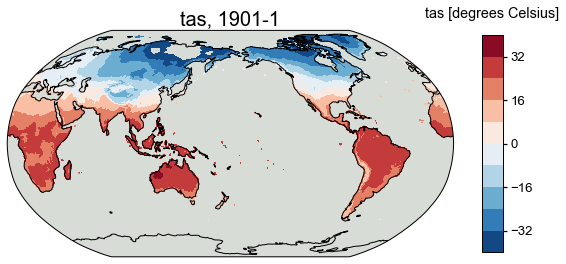

In [6]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [7]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 1.74 s, sys: 435 ms, total: 2.17 s
Wall time: 2.18 s


In [8]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

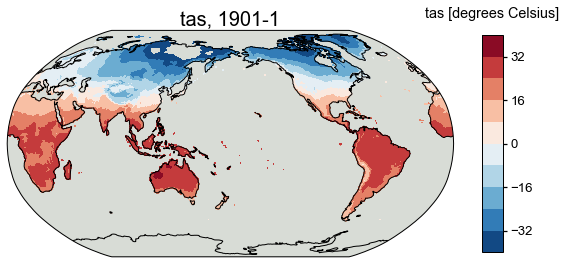

In [9]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [10]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [11]:
obs_pr_new = obs_pr.wrap_lon()

In [12]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [16]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

CPU times: user 333 ms, sys: 4.79 s, total: 5.12 s
Wall time: 1min 36s


In [17]:
pobj.clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ 0.4       ,  0.1       ,  0.5       , ..., 10.3       ,
        2.9       ,  0.90000004], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [18]:
lr_mdl = cfr.psm.Bilinear(pobj)

In [19]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list1=sn_list, season_list2=sn_list)

CPU times: user 939 ms, sys: 26.1 ms, total: 965 ms
Wall time: 966 ms


In [20]:
lr_mdl.calib_details

{'df':         proxy       tas          pr
 time                               
 1901.0  1.518  0.250000  173.850006
 1902.0  1.321  3.550000   54.516666
 1903.0  1.271  2.433333   58.216663
 1904.0  1.257  3.733333   62.250000
 1905.0  1.328  4.350000   73.733330
 ...       ...       ...         ...
 1988.0  1.212  3.866667  104.400002
 1989.0  1.293  3.450001   45.983334
 1990.0  1.405  3.050000   43.549999
 1991.0  1.221  3.683334   23.733332
 1992.0  1.178  4.300000   89.799995
 
 [92 rows x 3 columns],
 'nobs': 92.0,
 'fitR2adj': 0.2598948551151061,
 'PSMresid': time
 1901.0    0.134386
 1902.0    0.117901
 1903.0    0.149328
 1904.0    0.008127
 1905.0   -0.018394
             ...   
 1988.0   -0.212073
 1989.0    0.131634
 1990.0    0.287406
 1991.0    0.126061
 1992.0   -0.226526
 Length: 92, dtype: float64,
 'PSMmse': 0.037077056510313,
 'SNR': 0.6176750764917189,
 'seasonality': ([-9, -10, -11, -12, 1, 2], [-9, -10, -11, -12, 1, 2])}

In [21]:
%%time
pp = lr_mdl.forward()

CPU times: user 153 ms, sys: 5.7 ms, total: 159 ms
Wall time: 155 ms


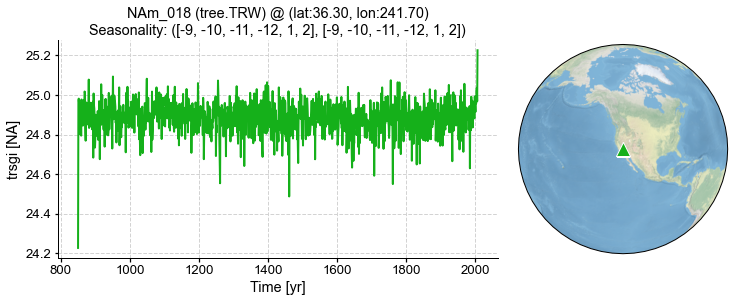

In [22]:
fig, ax = pp.plot()